In [81]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# from networkx.algorithms.link_prediction import preferential_attachment
#
# # Import all needed methods
# from cnlp.similarity_methods.local_similarity import common_neighbors, adamic_adar, jaccard, preferential_attachment
# from cnlp.similarity_methods.global_similarity import katz_index
#
# # Utils method
# from cnlp.utils import nodes_to_indexes
# from cnlp.utils import get_top_predicted_link


In [82]:
df = pd.read_csv('../data/processed/trade.csv')

In [83]:
# Calculate statistical measures
mean_value = df['PrimaryValue'].mean()
median_value = df['PrimaryValue'].median()
std_deviation = df['PrimaryValue'].std()

# Print the results
print("Statistical Analysis:")
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_deviation}")

# Show the count of record in each year
df['Period'].value_counts()

Statistical Analysis:
Mean: 80623860.64592639
Median: 49000.0
Standard Deviation: 1265471538.057834


Period
2021    6163
2019    6104
2018    6027
2016    5954
2020    5952
2017    5944
2015    5926
2014    5764
2013    5637
2012    5561
2011    5450
2010    5347
2006    5310
2009    5241
2008    5193
2007    5137
2005    4993
2004    4927
2003    4723
2002    4463
2001    4321
2000    4058
1999    3384
1998    3142
1997    2922
1996    2681
Name: count, dtype: int64

In [84]:
# Set the threshold for excluding extremely small trade values
threshold = 1000000

# Filter out values below the threshold
filtered_df = df[df['PrimaryValue'] >= threshold]

# Calculate statistical measures
mean_value = filtered_df['PrimaryValue'].mean()
median_value = filtered_df['PrimaryValue'].median()
std_deviation = filtered_df['PrimaryValue'].std()

# Print the results
print("Statistical Analysis:")
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_deviation}")

filtered_df['Period'].value_counts()

Statistical Analysis:
Mean: 322068494.7242492
Median: 9584514.0
Standard Deviation: 2515098879.739184


Period
2021    1616
2020    1485
2019    1463
2018    1446
2006    1436
2017    1411
2011    1383
2012    1371
2008    1353
2014    1352
2013    1347
2016    1342
2007    1335
2005    1333
2010    1333
2015    1306
2004    1300
2009    1243
2003    1184
2002    1109
2001    1090
2000    1045
1998     880
1999     874
1997     824
1996     732
Name: count, dtype: int64

In [85]:
# Split links by year
for i, g in filtered_df.groupby('Period'):
    globals()['period_' + str(i)] =  g

In [86]:
# Extract trade after 2013 for comparison of predicted and actual links
filtered_df_after_2013 = filtered_df[(filtered_df['Period'] >= 2013)][['Period','ReporterISO','PartnerISO']]
filtered_df_after_2013.to_csv('../data/processed/filtered_df_since_2013.csv',index=False)

#### Network structure

In [87]:
def create_graph(df):
    # Create an empty undirected graph
    G = nx.Graph()

    # Create links
    for _, row in df.iterrows():
        source = row['ReporterISO']
        target = row['PartnerISO']
        weight = row['PrimaryValue']

        # Add the edge to the network graph with the attributes
        G.add_edge(source, target, weight = weight)

    return G


def create_directed_graph(df):
    # Create an empty undirected graph
    G = nx.DiGraph()

    # Create links
    for _, row in df.iterrows():
        source = row['ReporterISO']
        target = row['PartnerISO']
        weight = row['PrimaryValue']

        # Add the edge to the network graph with the attributes
        G.add_edge(source, target, weight = weight )

    return G


def plot_network(G):
    # Extract edge weights for scaling link widths
    edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]
    max_edge_weight = max(edge_weights)

    # Calculate normalized link widths based on weights
    edge_widths = [width / max_edge_weight * 5 for width in edge_weights]

    # Set up colors for edges
    colors = [G[u][v].get('color', 'red') for u, v in G.edges()]

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 25), dpi=80)

    # Visualization 1
    pos_attrs1 = {}
    circPos1 = nx.shell_layout(G)
    for node, coords in circPos1.items():
        pos_attrs1[node] = (coords[0] + 0.01, coords[1] - 0.05)
    nx.draw_networkx_labels(G, pos=circPos1, ax=axes[0])
    nx.draw(G, pos=pos_attrs1, node_size=100, ax=axes[0], edge_color=colors, width=edge_widths)
    axes[0].set_title('Visualization 1')

    # Visualization 2
    pos_attrs2 = {}
    circPos2 = nx.spring_layout(G, k=0.2, iterations=20)
    for node, coords in circPos2.items():
        pos_attrs2[node] = (coords[0] + 0.01, coords[1] - 0.05)
    nx.draw_networkx_labels(G, pos=circPos2, ax=axes[1])
    nx.draw(G, pos=pos_attrs2, node_size=100, ax=axes[1], edge_color=colors, width=edge_widths)
    axes[1].set_title('Visualization 2')

    plt.tight_layout()
    plt.show()


def graph_info(G):
    # Number of Nodes
    num_nodes = len(G.nodes())
    # Number of Edges
    num_edges = len(G.edges())

    # Calculate clustering coefficient for each node
    clustering_coefficients = nx.clustering(G, weight='weight')
    # Calculate the average clustering coefficient
    average_clustering_coefficient = sum(clustering_coefficients.values()) / len(clustering_coefficients)

    # 打印计算结果
    print("Number of Nodes (|V|):", num_nodes)
    print("Number of Edges (|E|):", num_edges)
    print("Average clustering coefficient:", average_clustering_coefficient)
    print('*' * 20)

    # Calculate node centrality metrics
    in_degrees = dict(G.in_degree(weight='weight'))
    out_degrees = dict(G.out_degree(weight='weight'))
    page_rank = nx.pagerank(G, weight='weight')

    # Save results to DataFrames
    in_degrees_df = pd.DataFrame({'Code': list(G.nodes()), 'InDegree': list(in_degrees.values())})
    out_degrees_df = pd.DataFrame({'Code': list(G.nodes()), 'OutDegree': list(out_degrees.values())})
    page_rank_df = pd.DataFrame({'Code': list(G.nodes()), 'PageRank': list(page_rank.values())})

    # Sort by in-degree/out-degree/PageRank, and select top 10 Node
    in_degrees_top10 = in_degrees_df.sort_values(by='InDegree', ascending=False).head(10)
    out_degrees_top10 = out_degrees_df.sort_values(by='OutDegree', ascending=False).head(10)
    page_rank_top10 = page_rank_df.sort_values(by='PageRank', ascending=False).head(10)

    # Output top 10 results
    print("Top 10 In-Degree:")
    print(in_degrees_top10[['Code', 'InDegree']])
    print("Top 10 Out Degree:")
    print(out_degrees_top10[['Code', 'OutDegree']])
    # print("Top 15 Node Strength:")
    # print(node_strengths_top15[['Code', 'NodeStrength']])
    print("Top 10 PageRank:")
    print(page_rank_top10[['Code','PageRank']])


In [88]:
# Construct directed network
G_1996 = create_directed_graph(period_1996)
G_1999 = create_directed_graph(period_1999)
G_2002 = create_directed_graph(period_2002)
G_2005 = create_directed_graph(period_2005)
G_2008 = create_directed_graph(period_2008)
G_2011 = create_directed_graph(period_2011)
G_2012 = create_directed_graph(period_2013)
G_2013 = create_directed_graph(period_2014)
G_2014 = create_directed_graph(period_2014)
G_2015 = create_directed_graph(period_2015)
G_2016 = create_directed_graph(period_2016)
G_2017 = create_directed_graph(period_2017)
G_2018 = create_directed_graph(period_2018)
G_2019 = create_directed_graph(period_2019)
G_2020 = create_directed_graph(period_2020)
G_2021 = create_directed_graph(period_2021)


In [89]:
# Obtain the fundamental info of the network structure
graph_info(G_1996)
# graph_info(G_1999)
# graph_info(G_2002)
graph_info(G_2005)
# graph_info(G_2008)
# graph_info(G_2011)
graph_info(G_2014)
# graph_info(G_2017)
graph_info(G_2021)

Number of Nodes (|V|): 80
Number of Edges (|E|): 732
Average clustering coefficient: 0.004748969956205119
********************
Top 10 In-Degree:
   Code      InDegree
12  USA  2.906864e+10
8   SGP  1.486091e+10
6   MYS  1.247396e+10
5   JPN  1.042232e+10
22  TWN  9.472050e+09
4   HKG  8.395546e+09
3   DEU  7.403905e+09
21  KOR  6.540758e+09
11  GBR  5.944703e+09
40  CAN  5.517868e+09
Top 10 Out Degree:
   Code     OutDegree
12  USA  3.274928e+10
5   JPN  2.470952e+10
8   SGP  1.567250e+10
21  KOR  1.422852e+10
6   MYS  1.071825e+10
11  GBR  6.328927e+09
24  PHL  5.405737e+09
4   HKG  5.294065e+09
3   DEU  5.216323e+09
2   FRA  4.488732e+09
Top 10 PageRank:
   Code  PageRank
12  USA  0.135392
8   SGP  0.065676
3   DEU  0.055062
6   MYS  0.046116
5   JPN  0.043460
22  TWN  0.043110
4   HKG  0.042338
11  GBR  0.039936
21  KOR  0.032668
2   FRA  0.030854
Number of Nodes (|V|): 124
Number of Edges (|E|): 1333
Average clustering coefficient: 0.0013434900563748296
********************
Top 10 

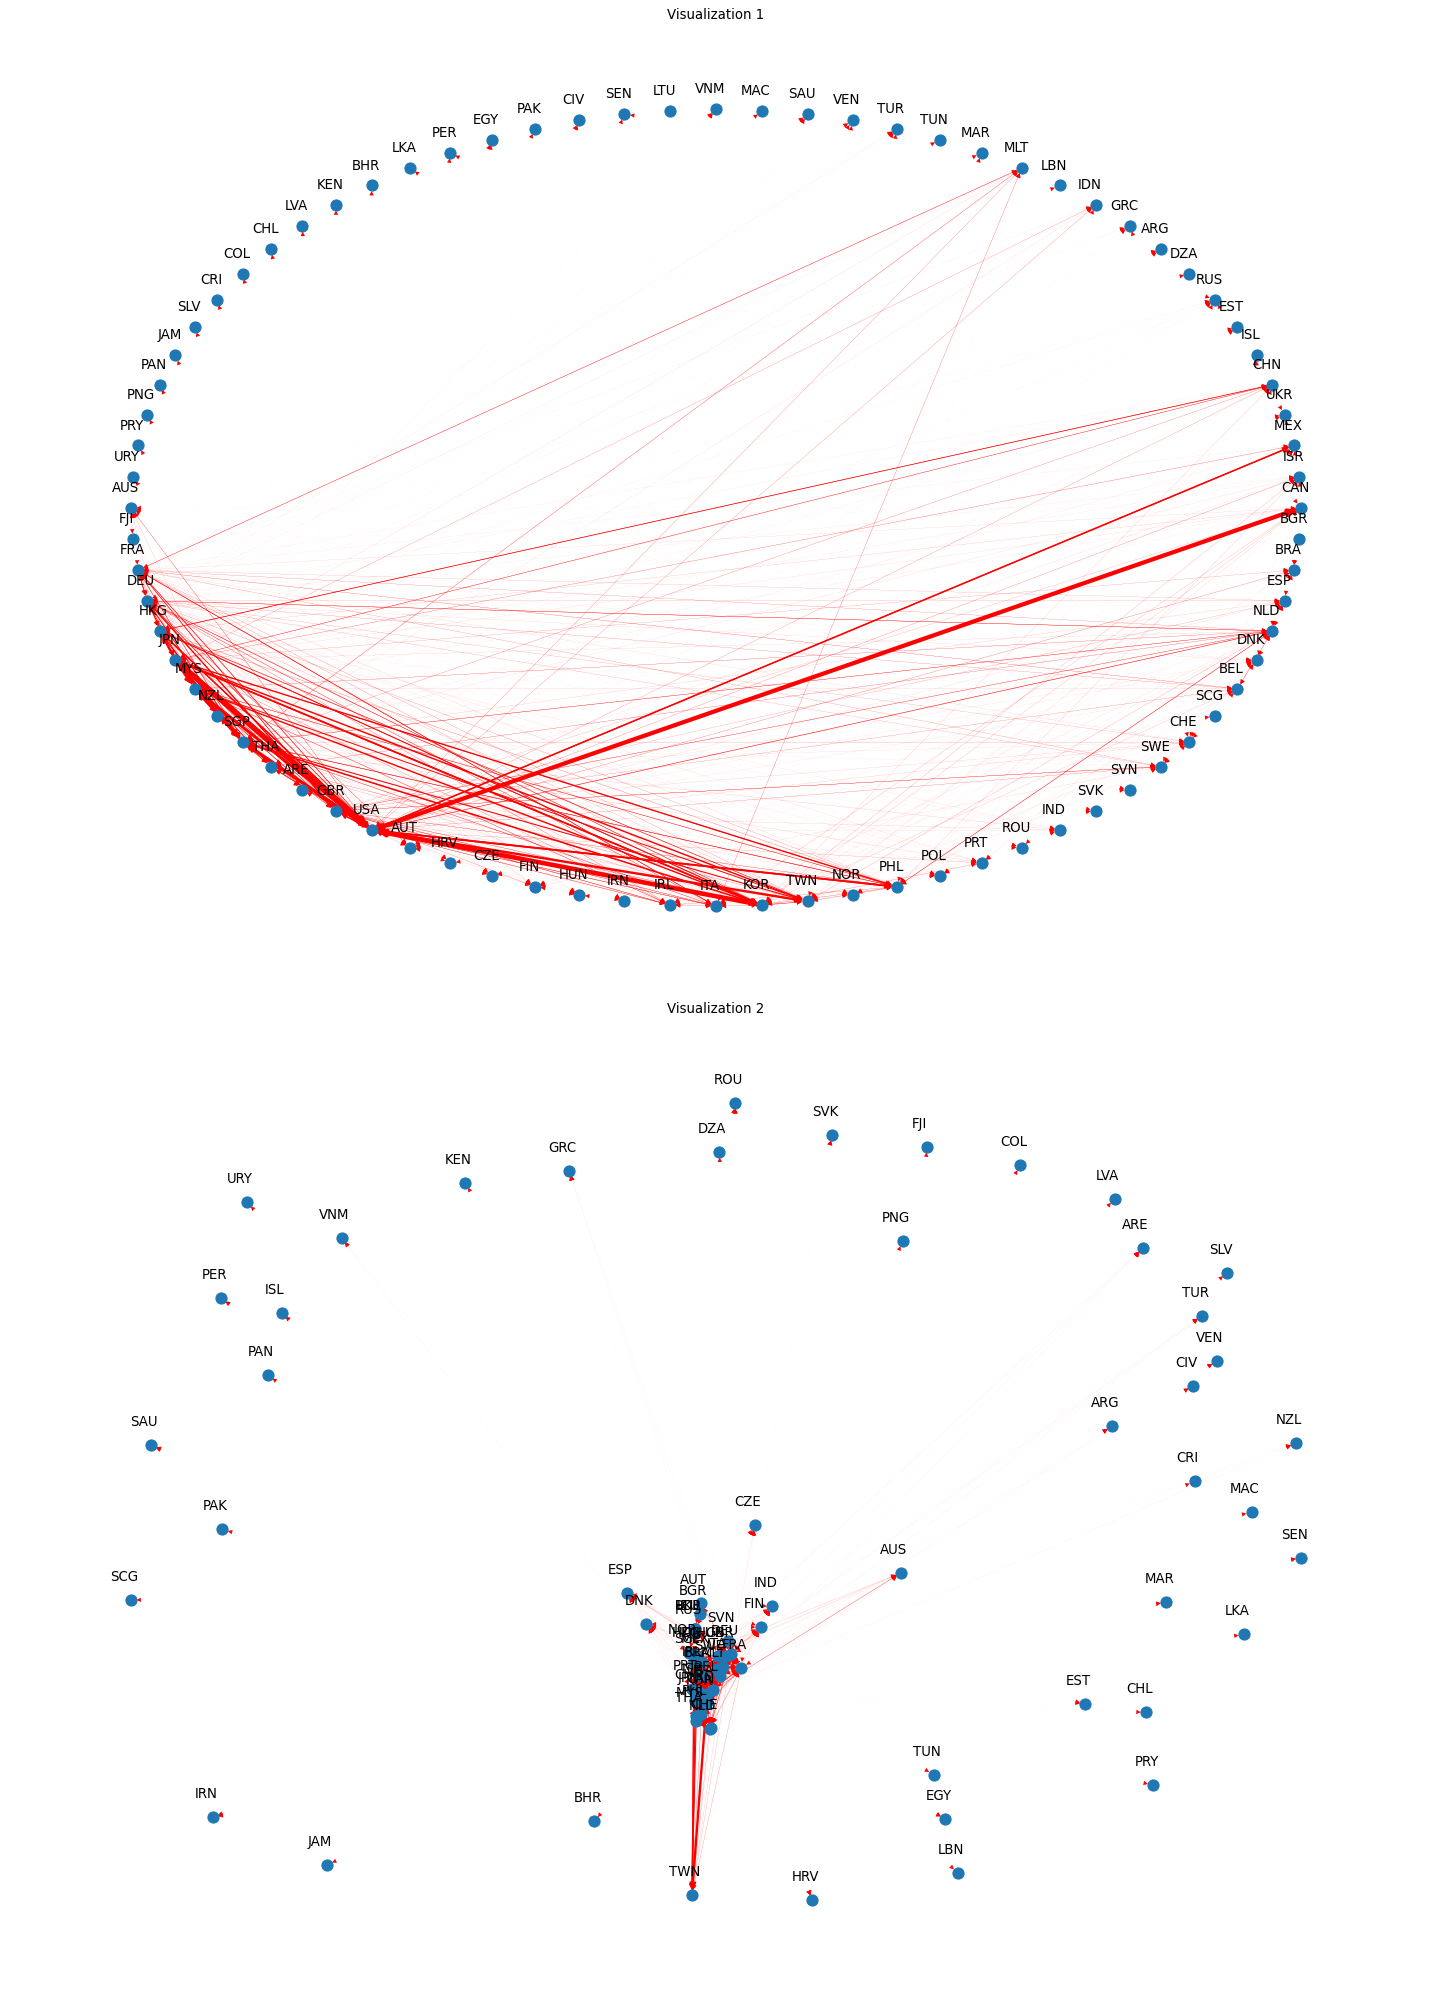

In [90]:
# Visilize the network
plot_network(G_1996)
# plot_network(G_2005)
# plot_network(G_2014 )
# plot_network(G_2021)


#### Link Prediction

In [91]:
# Create train and test sets
def split_train_test(G):
    # Get all nodes
    all_nodes = list(G.nodes())

    # Obtain the list of edges
    edges = list(G.edges())

    # Separate positive and negative edges
    positive_edges = list(G.edges())
    negative_edges = list([(source, target) for source in all_nodes for target in all_nodes if source != target and (source, target) not in positive_edges])

    # Split positive and negative edges into train and test sets
    positive_train, positive_test = train_test_split(positive_edges, test_size=0.1, random_state=42)
    negative_train, negative_test = train_test_split(negative_edges, test_size=0.1, random_state=42)

    # Combine train and test sets
    train_edges = positive_train + negative_train
    test_edges = positive_test + negative_test

    test_edges = [(source, target) for source, target in test_edges]

    return test_edges


In [92]:
def auc_cn(G):
    test_edges = split_train_test(G)
    # Common Neighbors
    # Calculate common neighbors for test set
    common_neighbors = [(u, v, len(list(nx.common_neighbors(G, u, v)))) for u, v in test_edges]

    # Sort by common neighbors in descending order
    common_neighbors_scores = {}
    for u, v in test_edges:
        common_neighbors = list(nx.common_neighbors(G, u, v))
        common_neighbors_scores[(u, v)] = sum([G[u][n]['weight'] for n in common_neighbors])

    # Create labels for the test edges (1 for existing edges, 0 for non-existing edges)
    test_labels = [1 if G.has_edge(u, v) else 0 for u, v in test_edges]

    # Calculate AUC
    auc_score = roc_auc_score(test_labels, list(common_neighbors_scores.values()))

    print(f"AUC for Common Neighbors on Weighted Network: {auc_score}")

def auc_aa(G):
    test_edges = split_train_test(G)

    # Calculate the Adamic-Adar score for each test edge
    adamic_adar_scores = {}
    for u, v in test_edges:
        adamic_adar = sum([1 / G.degree(n, weight='weight') for n in nx.common_neighbors(G, u, v)])
        adamic_adar_scores[(u, v)] = adamic_adar

    # Create labels for the test edges (1 for existing edges, 0 for non-existing edges)
    test_labels = [1 if G.has_edge(u, v) else 0 for u, v in test_edges]

    # Calculate AUC
    auc_score = roc_auc_score(test_labels, list(adamic_adar_scores.values()))

    print(f"AUC for Adamic-Adar on Weighted Network: {auc_score}")

def auc_pa(G):
    test_edges = split_train_test(G)
    # Preferential Attachment
    # Calculate the preferential attachment score for each test edge
    preferential_attachment_scores = {}
    for u, v in test_edges:
        pa_score = G.degree(u, weight='weight') * G.degree(v, weight='weight')
        preferential_attachment_scores[(u, v)] = pa_score

    # Create labels for the test edges (1 for existing edges, 0 for non-existing edges)
    test_labels = [1 if G.has_edge(u, v) else 0 for u, v in test_edges]

    # Calculate AUC
    auc_score = roc_auc_score(test_labels, list(preferential_attachment_scores.values()))

    print(f"AUC for Preferential Attachment on Weighted Network: {auc_score}")


def auc_jaccard(G):
    test_edges = split_train_test(G)

    # Calculate the Jaccard coefficient score for each test edge
    jaccard_scores = {}
    for u, v in test_edges:
        common_neighbors = list(nx.common_neighbors(G, u, v))
        if len(common_neighbors) == 0:
            jaccard_score = 0.0
        else:
            jaccard_score = sum(G[u][w]['weight'] * G[v][w]['weight'] for w in common_neighbors) / \
                            sum(G[u][w]['weight'] + G[v][w]['weight'] for w in common_neighbors)
        jaccard_scores[(u, v)] = jaccard_score

    # Create labels for the test edges (1 for existing edges, 0 for non-existing edges)
    test_labels = [1 if G.has_edge(u, v) else 0 for u, v in test_edges]

    # Calculate AUC
    auc_score = roc_auc_score(test_labels, list(jaccard_scores.values()))

    print(f"AUC for Jaccard Coefficient on Weighted Network: {auc_score}")


def link_prediction_method_auc(G):
    auc_cn(G)
    auc_aa(G)
    auc_pa(G)
    auc_jaccard(G)

In [93]:
G_2012 = create_graph(period_2012)
G_2013 = create_graph(period_2013)
G_2014 = create_graph(period_2014)
G_2015 = create_graph(period_2015)
G_2016 = create_graph(period_2016)
G_2017 = create_graph(period_2017)
G_2018 = create_graph(period_2018)
G_2019 = create_graph(period_2019)
G_2020 = create_graph(period_2020)
G_2021 = create_graph(period_2021)


In [94]:
print('*********2012*********')
link_prediction_method_auc(G_2012)
print('*********2013*********')
link_prediction_method_auc(G_2013)
print('*********2014*********')
link_prediction_method_auc(G_2014)
print('*********2015*********')
link_prediction_method_auc(G_2015)
print('*********2016*********')
link_prediction_method_auc(G_2016)
print('*********2017*********')
link_prediction_method_auc(G_2017)
print('*********2018*********')
link_prediction_method_auc(G_2018)
print('*********2019*********')
link_prediction_method_auc(G_2019)
print('*********2020*********')
link_prediction_method_auc(G_2020)
print('*********2021*********')
link_prediction_method_auc(G_2021)


*********2012*********
AUC for Common Neighbors on Weighted Network: 0.8842760094324363
AUC for Adamic-Adar on Weighted Network: 0.9257557441664469
AUC for Preferential Attachment on Weighted Network: 0.9308316378216861
AUC for Jaccard Coefficient on Weighted Network: 0.8751521703967923
*********2013*********
AUC for Common Neighbors on Weighted Network: 0.8793275092317274
AUC for Adamic-Adar on Weighted Network: 0.9110245682358411
AUC for Preferential Attachment on Weighted Network: 0.9405178538536432
AUC for Jaccard Coefficient on Weighted Network: 0.8709268566516677
*********2014*********
AUC for Common Neighbors on Weighted Network: 0.8653345074397706
AUC for Adamic-Adar on Weighted Network: 0.912298764930344
AUC for Preferential Attachment on Weighted Network: 0.9336178283546706
AUC for Jaccard Coefficient on Weighted Network: 0.8691074533179796
*********2015*********
AUC for Common Neighbors on Weighted Network: 0.8845863345338135
AUC for Adamic-Adar on Weighted Network: 0.907417

#### Obtainig predicted links

In [115]:
def get_new_links(G):

    # Find all nodes in the network
    all_nodes = list(G.nodes())

    # Find existing edges in the network
    existing_edges = list(G.edges())

    # Find potential connections (unexisting edges)
    potential_connections = [(source, target) for source in all_nodes for target in all_nodes if source != target and (source, target) not in existing_edges]

    # # Print the potential connections
    # for src, tgt in potential_connections:
    #     print(f"Potential Connection: {src} - {tgt}")

    # Calculate PA scores for potential connections
    pa_scores = []
    for src, tgt in potential_connections:
        pa_score = G.degree(src, weight='weight') * G.degree(tgt,weight='weight')
        pa_scores.append((src, tgt, pa_score))

    # Sort potential connections by PA score in descending order
    pa_scores.sort(key=lambda x: x[2], reverse=True)

    # Get the top 10 potential connections
    top_potential_connections = pa_scores[:10]

    # Print the top 10 potential connections with their PA scores
    for src, tgt, pa_score in top_potential_connections:
        # print(f"Source: {src}, Target: {tgt}, PA Score: {pa_score}")
        print(f"{src} - {tgt}")


In [116]:
# print("-------2012---------")
# get_new_links(G_2012)
# print("-------2013---------")
# get_new_links(G_2013)
# print("-------2014---------")
# get_new_links(G_2014)
# print("-------2015---------")
# get_new_links(G_2015)
# print("-------2016---------")
# get_new_links(G_2016)
# print("-------2017---------")
# get_new_links(G_2017)
# print("-------2018---------")
# get_new_links(G_2018)
# print("-------2019---------")
# get_new_links(G_2019)
# print("-------2020---------")
# get_new_links(G_2020)
print("-------2021---------")
get_new_links(G_2021)


-------2021---------
HKG - CHN
TWN - CHN
TWN - HKG
SGP - CHN
KOR - CHN
SGP - HKG
KOR - HKG
USA - CHN
MYS - CHN
USA - HKG
